In Cheminformatics, we frequently run into situations where we want to compare more than two datasets.  When comparing multiple datasets, we have a higher probability of chance correlation so we must make a few adjustments to the ways in which we compare our data.  In this notebook, we will examine the impact of multiple comparisons and talk about methods known as post-hoc tests that can be used to correct p-values when multiple comparisons are performed.  We will also make a brief foray into non-parametric statistics, a technique that is appropriate for dealing with the skewed data distributions that we often encounter in drug discovery. 

Import a few libraries that we'll need

In [1]:
import pandas as pd
import seaborn as sns
import scikit_posthocs as sp
import matplotlib.pyplot as plt
from scipy.stats import shapiro

Read the data table from Table S2 of the supporting material from [How to Improve Docking Accuracy of AutoDock4.2: A Case Study Using Different Electrostatic Potentials](https://pubs.acs.org/doi/pdf/10.1021/ci300417y)

In [2]:
df = pd.read_csv("li_table_S2.csv")

Let's look at the first few line of the data frame.  This table shows the RMSD between the docked ligand and the x-ray ligand when docking ligand from the PDB into native crystal structure using AutoDock 4.2.  The authors examined the imapact of different charging schemes on the quality of the docking solutions, as measured by RMSD.  The first column in the table is PDB id, subsequent columns are the charging methods used. 

In [3]:
df.head()

,PDB,AM1-BCC,Del-Re,formal,G-H,G-M,Hückel,MMFF,Pullman,HF
0,1S39,0.25,0.39,1.39,0.23,1.39,0.38,0.26,0.32,0.29
1,1ULB,0.67,0.63,0.72,0.72,0.67,0.72,0.67,0.73,0.65
2,2CPP,2.10,2.12,2.17,1.00,2.12,2.16,2.11,1.92,2.10
3,1DWB,0.68,1.92,1.93,1.92,1.93,1.93,1.92,1.94,0.52
4,3PTB,0.42,0.32,0.39,0.37,0.45,0.47,0.54,0.31,3.60


In order to plot this data we need to convert the data from a "wide" format to a "tall" format where we have one column that indicates the charging method and another that has the corresponding RMSD.  We can use the [melt](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html) method for Pandas data frames to do this. 

In [4]:
df_m = df.melt(id_vars=["PDB"],value_vars=df.columns[1:],var_name="Method",value_name="RMSD")

If we look at the first few lines of the melted dataframe we can see that we now have three columns and the data is in the appropriate form for plotting. 

In [5]:
df_m.head()

,PDB,Method,RMSD
0,1S39,AM1-BCC,0.25
1,1ULB,AM1-BCC,0.67
2,2CPP,AM1-BCC,2.10
3,1DWB,AM1-BCC,0.68
4,3PTB,AM1-BCC,0.42


Let's start out by looking at the distribution of the data.  As we can see below, these don't look like normal (aka Gaussian) distributions.

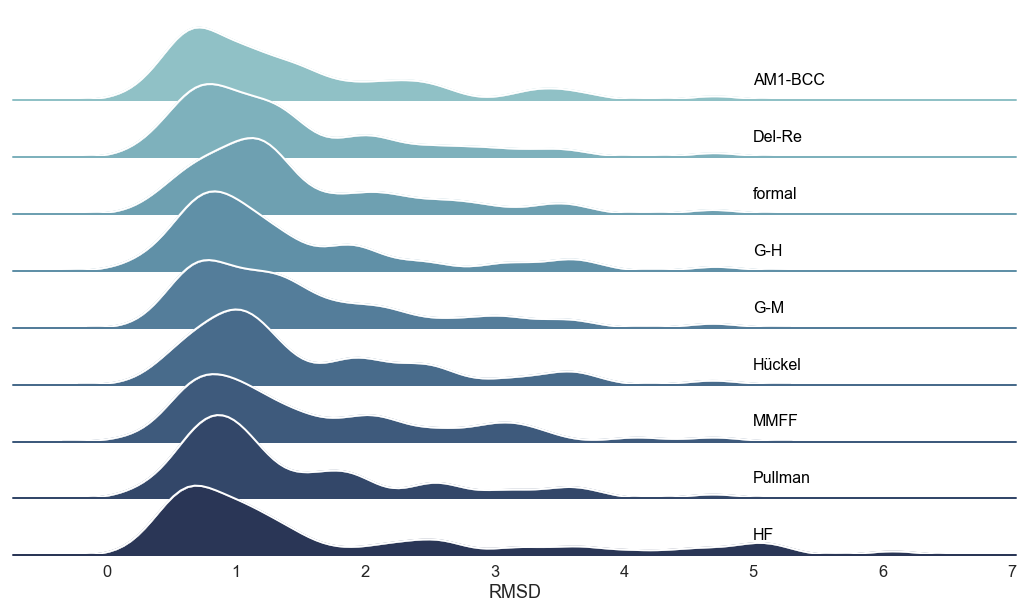

In [6]:
def label(x, color, label):
    ax = plt.gca()
    ax.text(5,0.15,label,color="black",fontsize=16)

# set up the plot aesthetics
sns.set(rc={'figure.figsize':(10,8)})
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)},font_scale=1.5)
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

# set up the facet grid
g = sns.FacetGrid(df_m, row="Method", hue="Method", aspect=15, height=1, palette=pal)

# plot the kde plots
g.map(sns.kdeplot,"RMSD",clip_on=True,shade=True,alpha=1,lw=1.5,bw=0.2)
g.map(sns.kdeplot, "RMSD", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# put the target names on the plots
g.map(label,"Method")

# a bunch of fiddling to make the plots pretty
g.despine(bottom=True, left=True)
g.fig.subplots_adjust(hspace=-0.35)
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
_ = g.axes[-1][0].set_xlabel("RMSD")

In order to be more quantitative about whether the distributions are normal, we'll do a Shapiro-Wilk test. In the Shapiro-Wilk test, the null hypothesis is that the data normal distributed, thus a p-value less than a chosen alpha (typically 0.05) indicates that the data is not normally distributed. As we can see below, all of the p-values are signficant, indicating that none of the distributions is normal. As such, we're going to be better of using non-parametic statistics.  We'll use the Mann-Whitney test below. For more information on statistical tests for normality see [this post](https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/) by Jason Brownlee

In [7]:
for method in df_m.Method.unique():
    vals = df_m.query(f"Method == '{method}'").RMSD.values
    p = shapiro(vals)[1]
    print(f"{method:10s} {p:.2e}")

AM1-BCC    1.47e-05
Del-Re     1.12e-05
formal     2.45e-05
G-H        3.62e-06
G-M        2.30e-05
Hückel     3.54e-05
MMFF       1.34e-04
Pullman    5.97e-06
HF         1.06e-06


Let's make a bar plot of the data.  While this tends to be that way that people look at distributions, it's not a great way to look at data.  See my [blog post](https://practicalcheminformatics.blogspot.com/2019/03/plotting-distributions.html) on plotting distributions for more information.

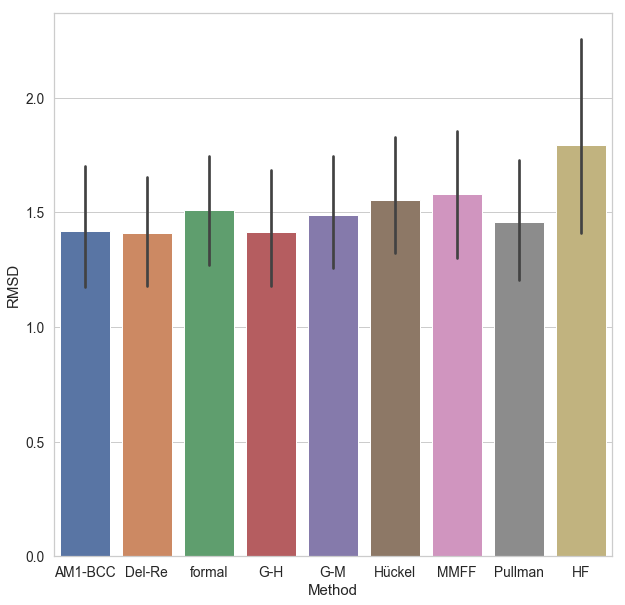

In [8]:
sns.set(style="whitegrid",rc={'figure.figsize':(10,10)},font_scale=1.25)
_ = sns.barplot(x="Method",y="RMSD",data=df_m)

If we look at the plot above, it looks like the Hartee-Fock charges (on the right) didn't perform well. Let's make a box plot to better view of the data.  Now we can see that medians of all nine distribuitions are similar. 

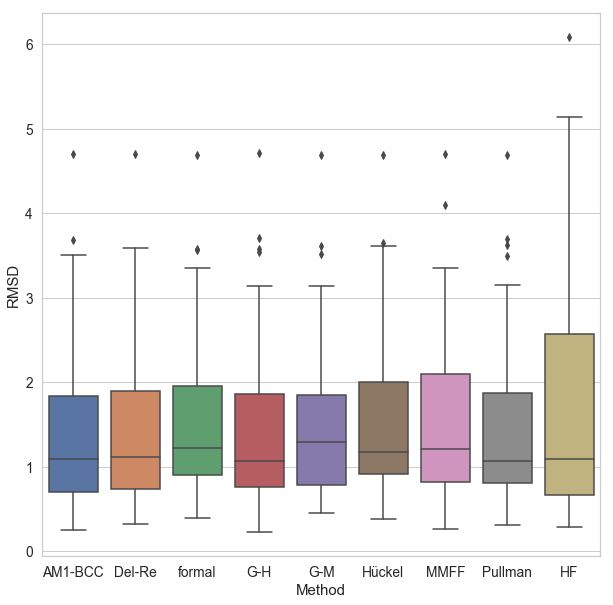

In [9]:
_ = sns.boxplot(x="Method",y="RMSD",data=df_m)

Let's use the Mann-Whitney test with Holm's method from [SciKit Posthocs](https://pypi.org/project/scikit-posthocs/) to compare the p-values and see if the distributions are different.  As we can see below, all of the cells in the table are red, indicating that none of the differences are signficant. 

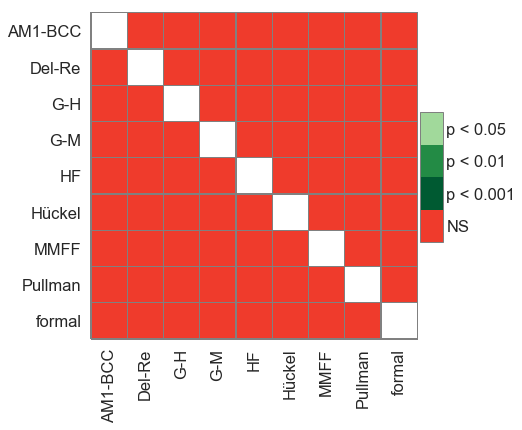

In [10]:
sns.set(rc={'figure.figsize':(8,6)},font_scale=1.5)
pc = sp.posthoc_mannwhitney(df_m,val_col="RMSD",group_col="Method",p_adjust='holm')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
_ = sp.sign_plot(pc, **heatmap_args)


Ok, I'll admit it, that was a letdown. We did all that work and none of the differences were signficant.  Let's take a look at different dataset where we'll actually see a difference (I promise).  This dataset was taken from an analysis I did for a talk at the 2019 ACS Meeting in Orlando.  In this analysis, I compared the solubility of acidic, basic, neutral, and zwitterionic compounds.  This dataset was taken from data generated at AstraZeneca that was contributed to the ChEMBL database. 

In [11]:
sol_df = pd.read_csv("ChEMBL_AZ_Solubility.csv")

As before, we'll take a look at the first few lines of the dataframe.  In this case we have 
```
SMILES - the SMILES string for the molecule
Sol_uM - the thermodynamic solubility of the compound in uM
Acidic_pKa - the calculated acidic pKa for the molecule
Basic_pKa - the calculated basic pKa for the molecule
Charge_State - the calculated charge state for the molecule at pH 7.4
```

In [12]:
sol_df.head()

,SMILES,MOLREGNO,Sol_uM,Acidic_pKa,Basic_pKa,Charge_State
0,OC(=O)c1cc2cc(Cl)ccc2n1Cc3ccc(Cl)c(Cl)c3,217385,81.3,4.76,NaN,acidic
1,COc1cc(OC2CNC2)ccc1Nc3ncc(Cl)c(n3)c4cnc5ccccn45,1166753,81.3,13.54,8.60,basic
2,CCOC(=O)Nc1ccc2Sc3ccccc3N(C(=O)CCN4CCOCC4)c2c1,139866,83.2,12.90,6.73,neutral
3,Nc1nc(cs1)c2ccc(Cl)cc2,1061805,83.2,16.70,4.07,neutral
4,CC(C)c1ccc2[nH]c3CCN(Cc3c2c1)C(=O)[C@@H]4CCCC[...,1428120,83.2,11.93,-0.35,neutral


Define a couple of lists to set the order and colors for the boxplot

In [13]:
sol_order = ["acidic","basic","neutral","zwitterionic"]
sol_pal = ["pink","lightblue","lightgreen","violet"]

Draw the boxplot.  We can see that neutral compounds are less soluble than charged compounds.  It also looks like there's some difference between acidic and basic compounds.

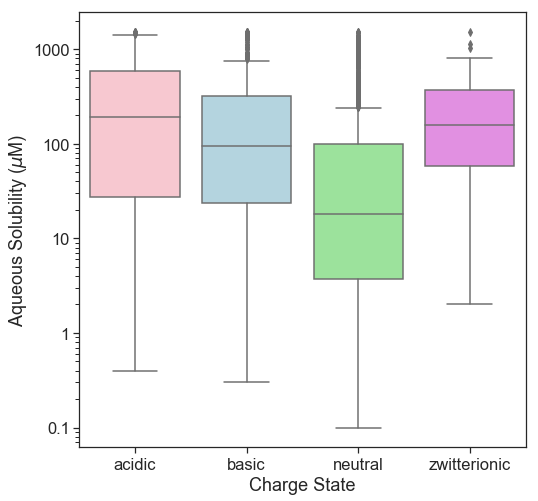

In [14]:
sns.set(rc={'figure.figsize':(8,8)},font_scale=1.5)
sns.set_style('ticks')
ax = sns.boxplot(x="Charge_State",y="Sol_uM",data=sol_df,order=sol_order,palette=sol_pal)
ax.set(xlabel="Charge State",ylabel="Aqueous Solubility ($\mu$M)")
ax.set(yscale="log")
ax.set_yticks([0.1,1,10,100,1000])
_ = ax.set_yticklabels(["0.1","1","10","100","1000"])

Let's use scikit-posthocs to see if any of these differences are significant. If we look at the first row in the table below, we can see that there is a significant difference between the solubility of acidic and basic compounds (p < 0.05). The difference between acidic and neutral compounds is more significant (p < 0.001). However, the difference in the mean solubilities of the acidic and zwitterionic compounds is not significant. We can look across subsequent columns to examine the differences between basic, neutral, and zwitterionic compounds.

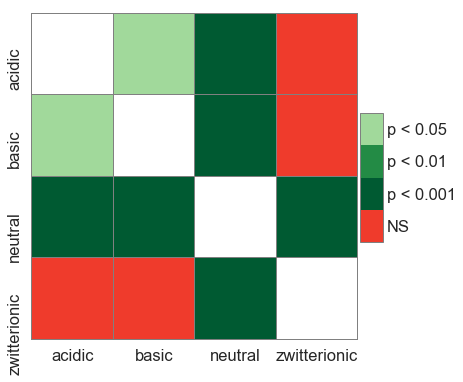

In [15]:
sns.set(rc={'figure.figsize':(8,6)},font_scale=1.5)
pc = sp.posthoc_mannwhitney(sol_df,val_col="Sol_uM",group_col="Charge_State",p_adjust='holm')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
_ = sp.sign_plot(pc, **heatmap_args)